# Analysing data

### Step 05

In order to analyse data we use different libraries (e.g. statsmodels, scikit-learn,...) with its various regressions- und clustering-algorithms.

* calculate rolling means(moving averages)
* resample time series data by the month, week, year, etc. if needed 
* diving into concepts such as trends, seasonality, first-order differencing, and autocorrelation


### Importing libraries and data

In [74]:
#import sys
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import dates as mdates
from matplotlib.axis import Axis
import seaborn as sns
import time
#import statsmodels.api as sm

#from datetime import date

g_len_list = 10 #global variable to show no of records in various steps

#-------------------- Example
#url='https://zamg_xxx_daily.csv'
#data = pd.read_csv(url,sep=",", index_col='id', parse_dates=['date'])

start_time = time.time()
# 01 import data from csv
print(f'>>> Fetching data...')
data = csv.DictReader(open(
    'C:/Users/andre/Nextcloud/WS_2023/IKT/25_AllData/DF_subset_90864_at_2024-01-12_100051.csv'),
    delimiter=",")
df = pd.DataFrame(data)
#to explicitly convert the date column to type DATETIME
df['UTC'] = pd.to_datetime(df['UTC']) #, utc=True)
#set date column as index
'''
df = df.set_index(pd.DatetimeIndex(df['UTC']))
df.sort_index(inplace=True)
df = df.asfreq(freq='10min') #when upsampling do a fill with specific value: df.asfreq(freq='30S', fill_value=9.0) OR (..., method='bfill')
#check the indices
df.index
'''
#define other column(s) as number
#df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1])  #temp gets values, not strings

print(f'...done')
# 02 show data
print(df)
'''
fig, ax = plt.subplots(figsize=(16,11))
ax.plot(df['UTC'])
ax.set_xlabel('Time')
'''
# 03 potentially reduce amount (also for testing)
#col_map = {df.columns.get_loc(c):c  for c in df.columns}
#print(f'\n>>> List of columns: ')
#print(col_map)
print(df.info())
'''
cols = input("Enter position of columns to look at (separated with ,):")
lis = cols.split(",")
list = [eval(i) for i in lis]
list_names = list(lis)
#print(f'Shortlist...')
#continue with lower # of rows
df = df.iloc[0:370000,list] #df = df.iloc[0:370000,[0,16,23,25]]
''' 
print(f'\n>>> Script finished after running %.2f seconds.' % (time.time() - start_time))


>>> Fetching data...
...done
                      UTC AG_Temp AG_Temp_FLAG AG_Wind AG_Wind_FLAG  \
0     2016-12-01 00:00:00     1.9          100  46.729          100   
1     2016-12-01 00:10:00     1.9          100   38.46          100   
2     2016-12-01 00:20:00   2.192          100  34.433          100   
3     2016-12-01 00:30:00   1.795          100  42.262          100   
4     2016-12-01 00:40:00    1.19          100  39.125          100   
...                   ...     ...          ...     ...          ...   
90859 2023-02-28 23:10:00  -1.219          500    0.72          500   
90860 2023-02-28 23:20:00  -1.219          500    0.72          500   
90861 2023-02-28 23:30:00    -1.5          100    0.72          500   
90862 2023-02-28 23:40:00    -1.5          500    0.72          500   
90863 2023-02-28 23:50:00    -1.5          500    0.72          500   

           AU_time AU_station  AU_DD AU_DD_FLAG AU_FFAM  ...  \
0      1.48055e+18       7710  289.0        100     9.

### Calculate simple moving averages

Data is available in 10mins intervals. So for yearly seasonality *6(h)*24(d)*365,25(yr) = 52596 periods are to be taken into account.
* Half Year: 26298
* Quarter: 13149 
  
As sometimes 30mins intervals are resampled to 10mins before analysis also a period of 17532 might be of interest.

For subsets other periods are used.

>>> Calculation of different (rolling) means:


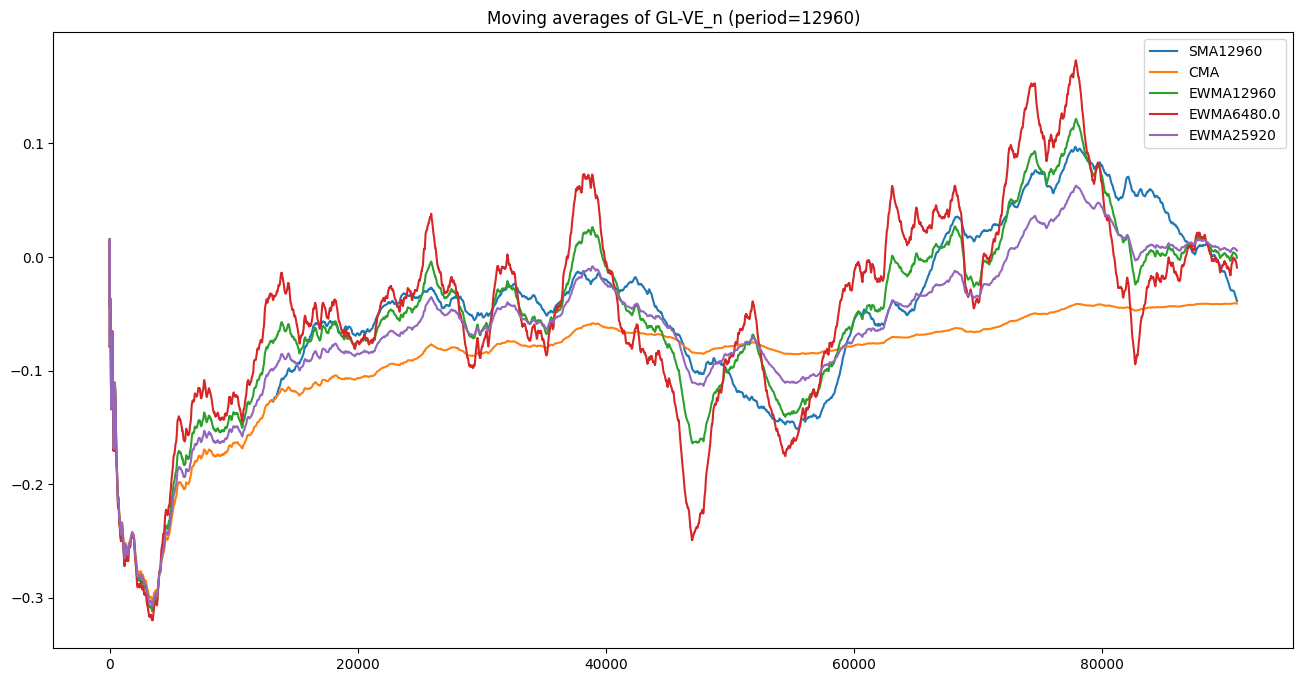

In [80]:
###define column to analyse and periodicity
#####
c = 57
period = 12960
'''
period = 52596 # 52596 #, period=17532) #10mins intervall data=1 *6(h)*24(d)*365,25(yr) = 52596 to get yearly data
'''
#####

#-------------------- Calculating means 
print(f'>>> Calculation of different (rolling) means:')

plt.style.use('default')
%matplotlib inline

cn = df.iloc[:, c].name
# updating our dataFrame to have only one column as rest all columns are of no use for us at the moment 
# using .to_frame() to convert pandas series into dataframe.
df_short = df[cn].to_frame()
# pd.to_numeric(df.iloc[:, 3])

# calculating simple moving average using .rolling().mean()
sma = 'SMA'+str(period)
df_short[sma] = df_short.iloc[:, 0].rolling(period).mean()  #rolling(window = 7, center = True).mean()

# calculating cumulative moving average using .expanding().mean()
# Cumulative moving average considers all prior observations, no dropping of oldest observations
df_short['CMA'] = df_short.iloc[:, 0].expanding().mean()

# calculating exponential moving average using .ewm(span).mean() , with window size = period
ewma = 'EWMA'+str(period)
df_short[ewma] = df_short.iloc[:, 0].ewm(span=period).mean()

ewma2 = 'EWMA'+str(period/2)
df_short[ewma2] = df_short.iloc[:, 0].ewm(span=period/2).mean()

ewma3 = 'EWMA'+str(period*2)
df_short[ewma3] = df_short.iloc[:, 0].ewm(span=period*2).mean()

# plotting value and exponential moving averages
#df_short[[cn, 'CMA', sma, ewma]].plot(title='Moving averages of '+cn, figsize=(16, 8))
title = 'Moving averages of '+cn+' (period='+str(period)+')'
df_short[[ sma, 'CMA', ewma, ewma2, ewma3]].plot(title=title, figsize=(16, 8))
date = time.strftime("%Y-%m-%d_%H%M%S")
plt.savefig(title+'_'+date+'.png', dpi=300, bbox_inches='tight')

### Linear regression

In [6]:
#-------------------- Simple trend
from scipy.stats import linregress

#linregress cannot work with dates, therefore the timestamp "number" is used
#x = np.arange(0,len(df)) #create simple number index artificially
x = pd.to_numeric(df['AU_time'])
#x = df['GA_time']#.resample("30min").mean()

df[df.iloc[:, c].name] = pd.to_numeric(df.iloc[:, c])
y = df[df.iloc[:, c].name]#.resample("30min").mean() #.round(3) "3T" T=mins 

print(f'>>> Simple trend analysis of '+cn)
res = linregress(x, y)
print(f'Equation: {res[0]:.3f} * t + {res[1]:.3f}, R^2: {res[2] ** 2:.2f} ')
print(res)   
# example LinregressResult(slope=4.32, intercept=13.274, rvalue=0.804, pvalue=0.0007, stderr=0.90, intercept_stderr=7.70)

>>> Simple trend analysis of KO-VE
0.000 * t + -0.551, R^2: 0.00 
LinregressResult(slope=5.064205449338377e-19, intercept=-0.5508509715962797, rvalue=0.05230834842281023, pvalue=4.39313030855622e-56, stderr=3.2074079231059976e-20, intercept_stderr=0.05068825795791852)


### Polynomial regression

In [7]:
#-------------------- Simple and polynomial trend
print(f'>>> Polynomial trend analysis of '+cn)
print(f'Polyfit_1:')
z = np.polyfit(x,y,1) # number is degree
print("{0}x + {1}".format(*z))
print(f'Polyfit_2:')
z = np.polyfit(x,y,2)
print("{0}x^2 + {1}x + {2}".format(*z))

>>> Polynomial trend analysis of KO-VE
Polyfit_1:
5.064205449338442e-19x + -0.5508509715962896
Polyfit_2:
2.7352123048255625e-36x^2 + -8.131868969062057e-18x + 6.25857450203695


### Time Series Decomposition

>>> (Partial) autocorrelation test of GL-VE_n


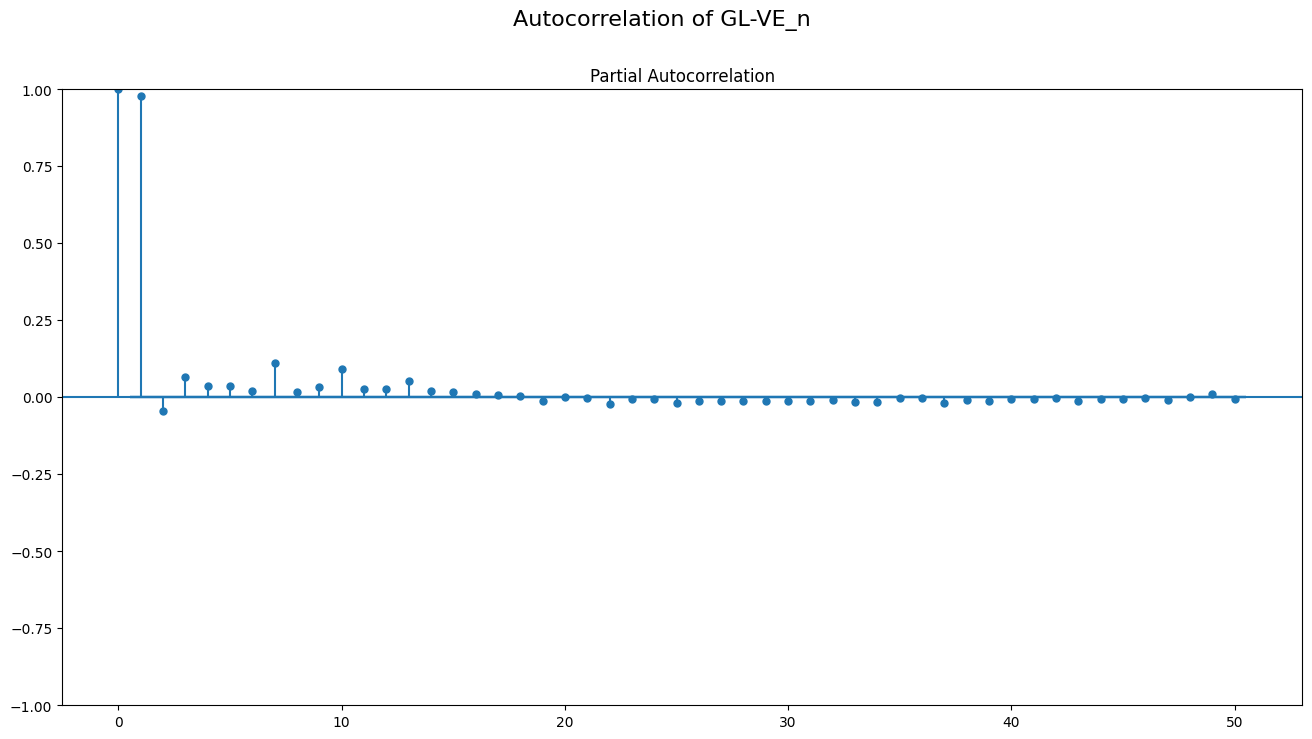


>>> Performing seasonal decomposition of GL-VE_n


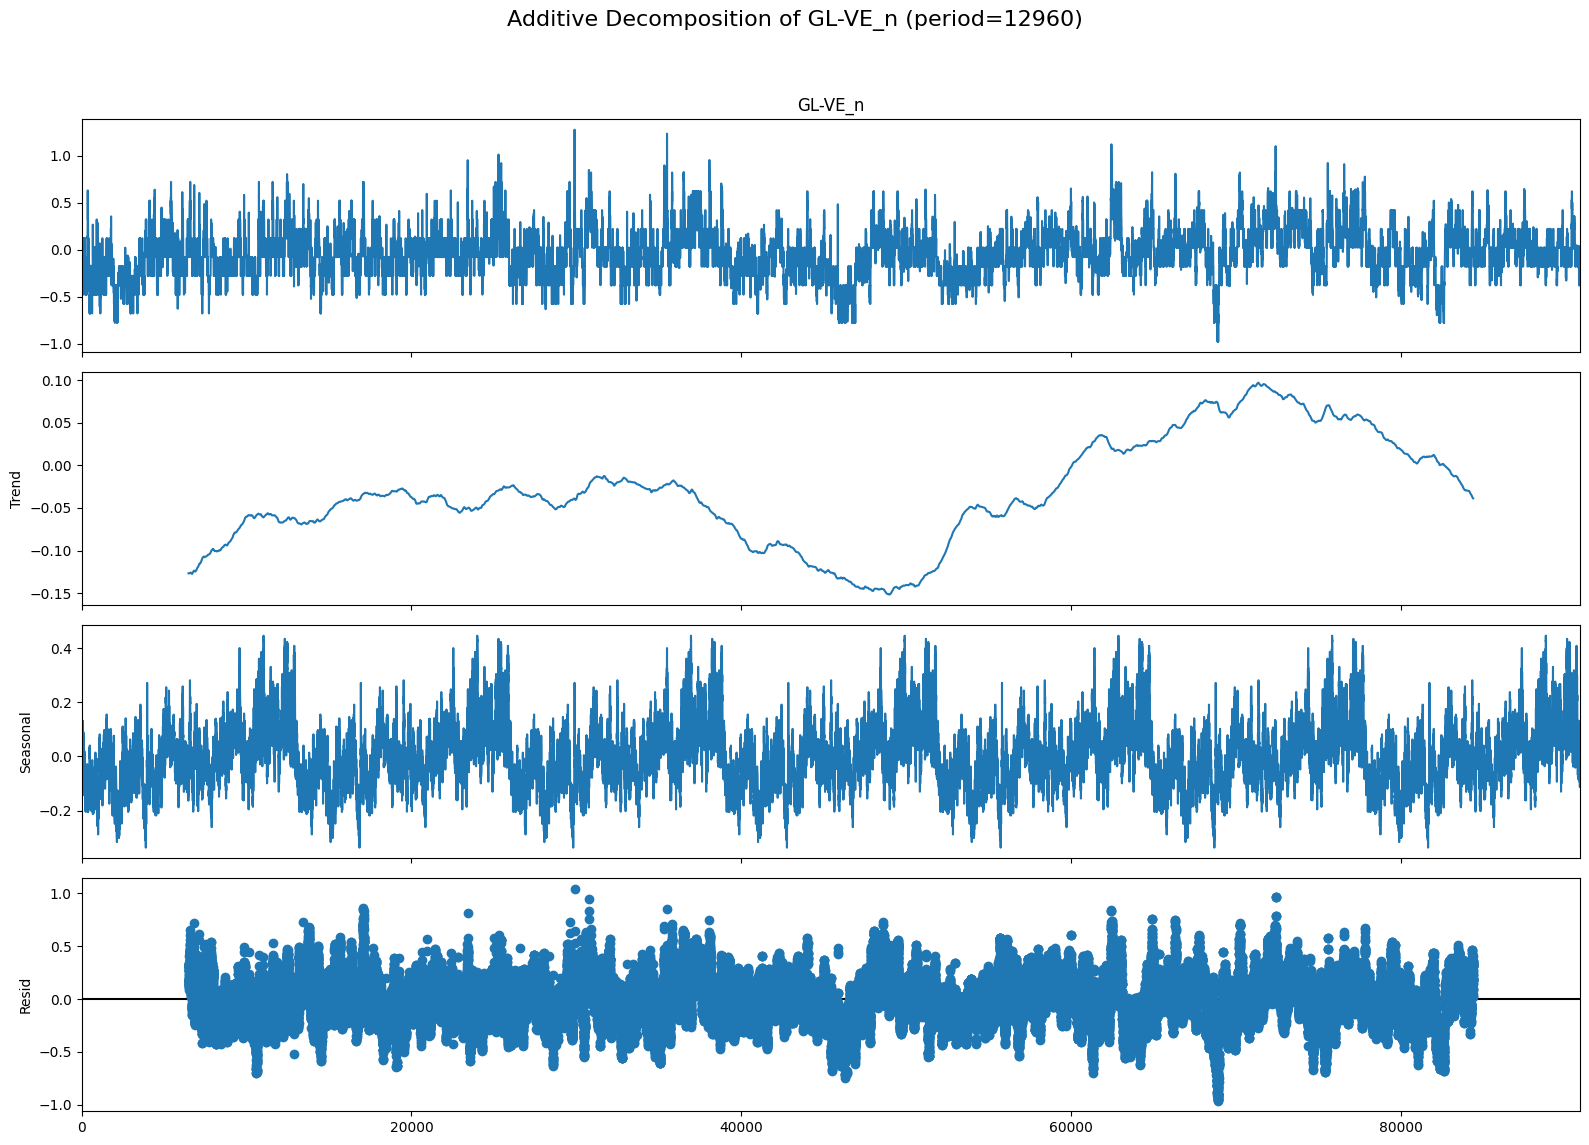

In [81]:
#-------------------- Example using statsmodels
#data = sm.datasets.co2.load_pandas().data

### if resampling takes place:
#df.iloc[:, c].resample("30min").mean()
#period = 17532 # 52596

from statsmodels.graphics.tsaplots import plot_pacf

print(f'>>> Quick (partial) autocorrelation test of '+cn)
plt.rcParams.update({'figure.figsize': (16,8)})
plot_pacf(df.iloc[:, c], lags=50) #, lags=50   17532
# Plot
plt.suptitle('Autocorrelation of '+cn, fontsize=16)
plt.show()
#x = pacf(df['Diff'], method='ywunbiased', alpha=None)
#print(x)

from statsmodels.tsa.seasonal import seasonal_decompose
#import statsmodels.tsa.stattools
from dateutil.parser import parse

print(f'\n>>> Performing seasonal decomposition of '+cn)

# Multiplicative Decomposition 
#multiplicative_decomposition = seasonal_decompose(df['Diff'], model='multiplicative', period=period)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df[cn], model='additive', period=period, two_sided=True) 

plt.rcParams.update({'figure.figsize': (16,12)})
#multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Plot
additive_decomposition.plot().suptitle('Additive Decomposition of '+cn+' (period='+str(period)+')', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

date = time.strftime("%Y-%m-%d_%H%M%S")
#fol = 'C:/Users/andre/Nextcloud/WS_2023/IKT/30_ResultGraphs/'
pngname = 'result_add_decomp'
plt.savefig(pngname+'_'+cn+'_'+str(period)+'_'+date+'.png', dpi=300, bbox_inches='tight')
plt.show()

### Time Series Decomposition (advanced)

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships.

>>> Performing STL decomposition of KO-VE


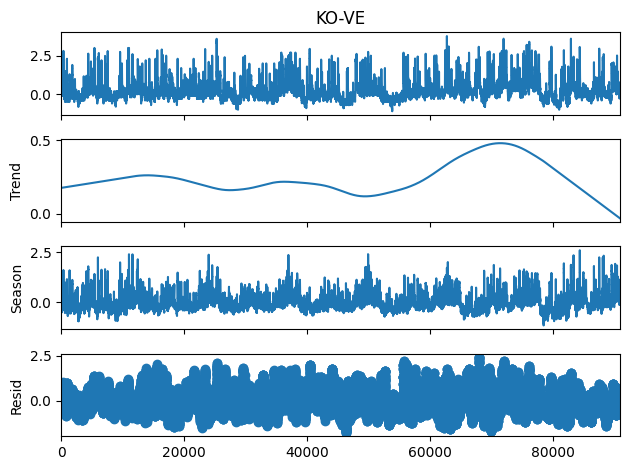


>>> Script finished after running 1828.42 seconds.


In [9]:
from statsmodels.tsa.seasonal import STL

#period = 12960

print(f'>>> Performing STL decomposition of '+cn)
start_time = time.time()
plt.style.use('default')
plt.rcParams.update({'figure.figsize': (16,8)})
stl_decomposition = STL(df[cn], period=period).fit()
stl_decomposition.plot() #.suptitle('STL Decomposition of '+cn+' (period='+str(period)+')', fontsize=16)
plt.show()
print(f'\n>>> Script finished after running %.2f seconds.' % (time.time() - start_time))

Autocorrelation can help identify seasonal patterns in a time series.

>>> Performing test for potentially finding seasonality of KO-VE


<Axes: title={'center': 'Autocorrelation of KO-VE (period=12960)'}, xlabel='Lag', ylabel='Autocorrelation'>

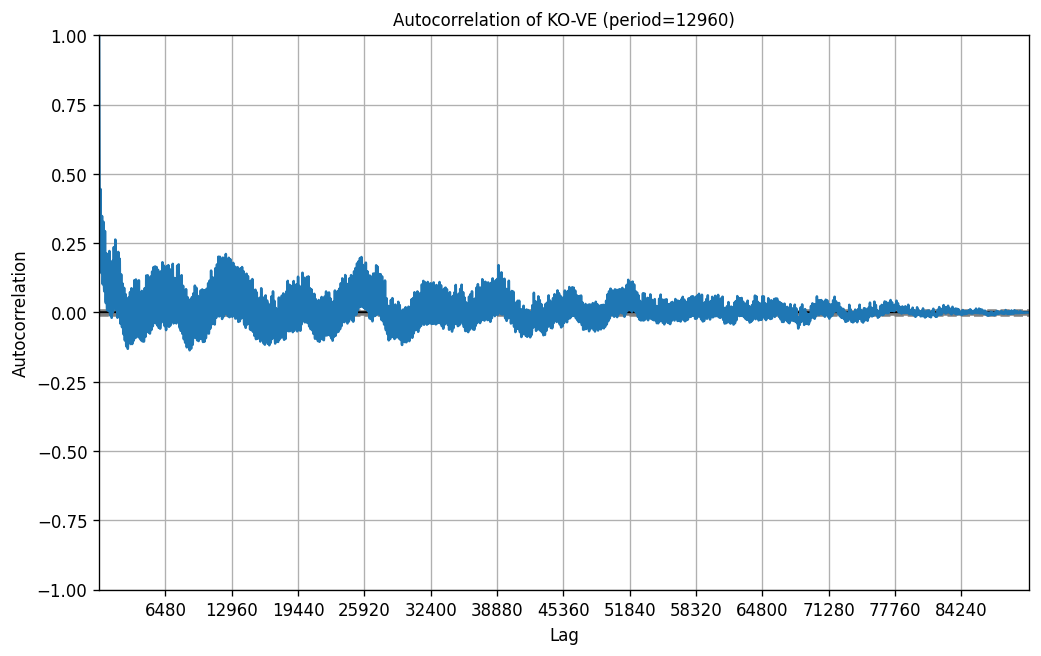

In [69]:
from pandas.plotting import autocorrelation_plot
#-------------------- Testing for seasonality
print(f'>>> Performing test for potentially finding seasonality of '+cn)

df_short = df[cn].astype(float)
s = pd.Series(df_short)
#df_short.info()
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
plt.xticks(np.arange(0, period*7, step=period/2))
plt.title('Autocorrelation of '+cn+' (period='+str(period)+')', fontsize=10)
autocorrelation_plot(s)


In [1]:
a = additive_decomposition.trend #.plot()
vgl = 'KO-VE_n'
additive_decomposition2 = seasonal_decompose(df[vgl], model='additive', period=period, two_sided=True) 
b = additive_decomposition2.trend #.plot()
df['AU_TL'] = df['AU_TL'].astype(float)
c = df['AU_TL']  #.plot()
df.index = range(len(df.index))
xs = df.index
#xs = df['UTC']

print(xs)
#fig, (ax1, ax2) = plt.subplots(2, figsize=(9,6))
fig, (ax1, ax2) = plt.subplots(2, figsize=(9,6))
ax1.plot(xs, a, label=a.name+' '+cn)                # plot rawsignal in the first Axes
ax1.plot(xs, b, label=b.name+' '+vgl)                # plot rawsignal in the first Axes
ax1.set_xlim(0, period*7)
ax1.set_ylim(-0.4, +0.6)
ax1.set_ylabel('Inside temp diff [°C]')
#ax1.set(title='Signal')                # set the title of the first Axes
ax1.legend(loc='upper left')

color = 'black' #'tab:green'
linewidth = 0.05
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(xs, c, color=color, linewidth=linewidth, label=c.name)   # plot FFT in the second Axes
ax2.set_xlim(0, period*7)
ax2.set_ylim(-20, +25)
#ax2.set_yticks(np.arange(-20, +50, step=2))
ax2.set_ylabel('Outside temp [°C]')
#ax2.set(ylim=(-15, +35),title='FFT')   # set title and y-limit of the second Axes
ax2.legend()
#fig.legend([a, b, c], ['label1', 'label2', 'label3'])


##ax2 = plt.subplot()
##ax2.set_ylim([-15, +35])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.show()

NameError: name 'additive_decomposition' is not defined

Scatter Plot: Any linear dependency of the inside temperature difference to outside temperatures is not visible...

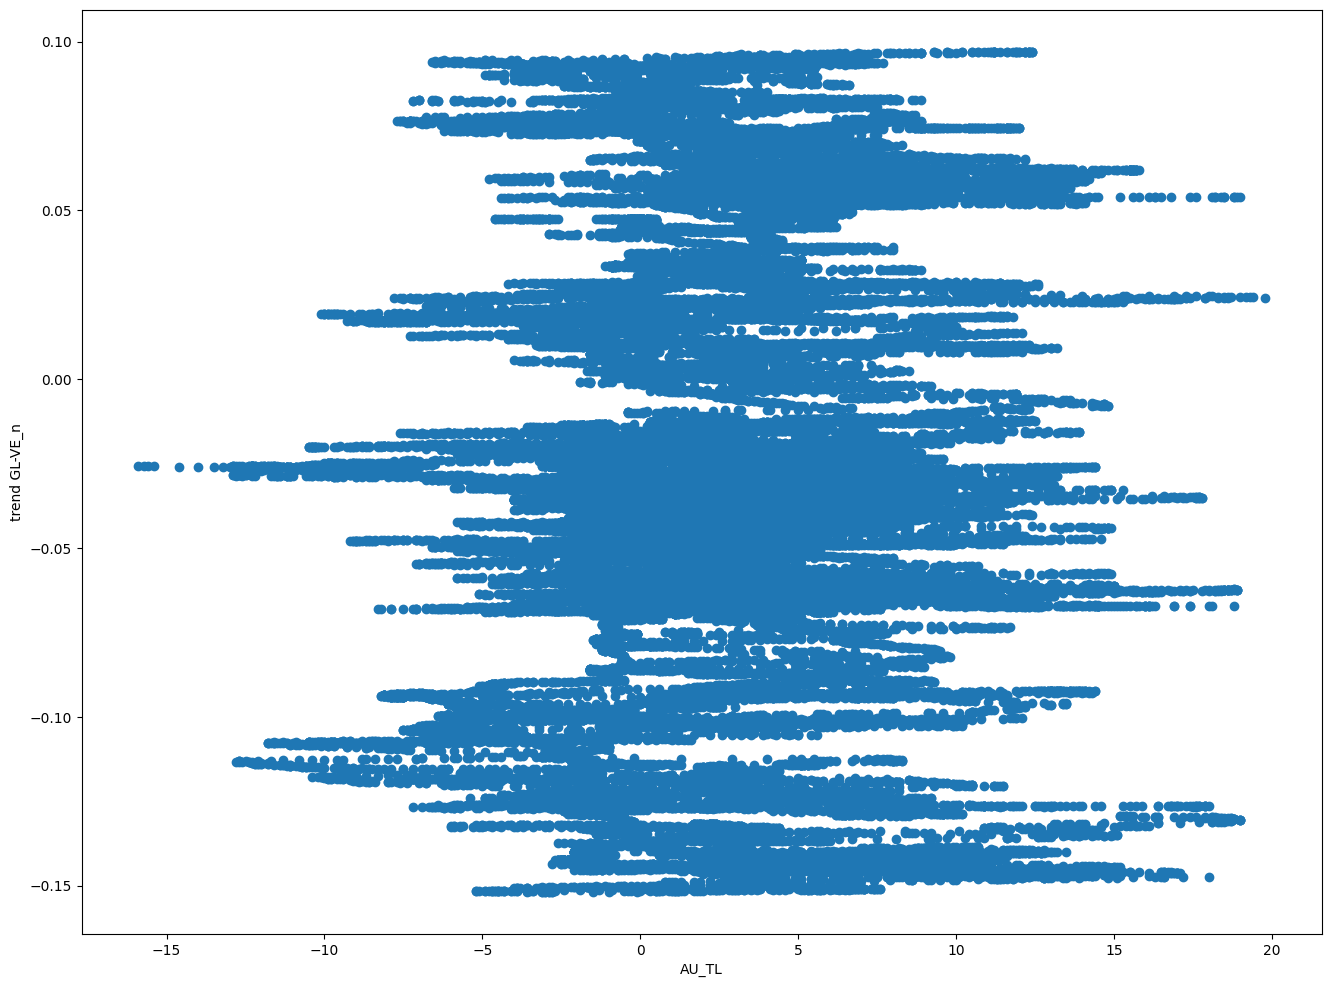

Polyfit_1:
nanx + nan
nan * t + nan, R^2: nan 
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = df['AU_TL'] #np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = a #np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])

plt.scatter(x, y)
plt.xlabel(x.name)
plt.ylabel(y.name+' '+cn)
plt.show()

#-------------------- Simple and polynomial trend
print(f'Polyfit_1:')
z = np.polyfit(x,y,1) # number is degree
print("{0}x + {1}".format(*z)) 

### Further analyses playground - DRAFT DRAFT DRAFT

           y
0     -0.300
1     -0.300
2      1.500
3      1.100
4      0.064
...      ...
32879  0.200
32880  0.152
32881  0.152
32882  0.152
32883  0.200

[32884 rows x 1 columns]
           y  lag_0  lag_519  lag_1038  lag_1557  lag_2076  lag_2595  \
32879  0.200  0.200    0.039     1.839     0.400     0.119     0.200   
32880  0.152  0.152    0.000     1.606     0.400     0.119     0.341   
32881  0.152  0.152    0.000     1.606     0.361     0.013     0.341   
32882  0.152  0.152    0.000     1.606     0.361     0.013     0.341   
32883  0.200  0.200    0.031     1.432     0.361     0.013     0.593   

       lag_3114  lag_3633  lag_4152  lag_4671  lag_5190  
32879     0.000     1.465      -0.2       0.0     0.471  
32880     0.000     1.465      -0.2       0.0     0.600  
32881     0.000     1.465      -0.2       0.0     0.600  
32882    -0.174     1.374      -0.2       0.0     0.600  
32883    -0.374     1.374      -0.2       0.0     0.529  
Linear regression of KO-VE
The coeffi

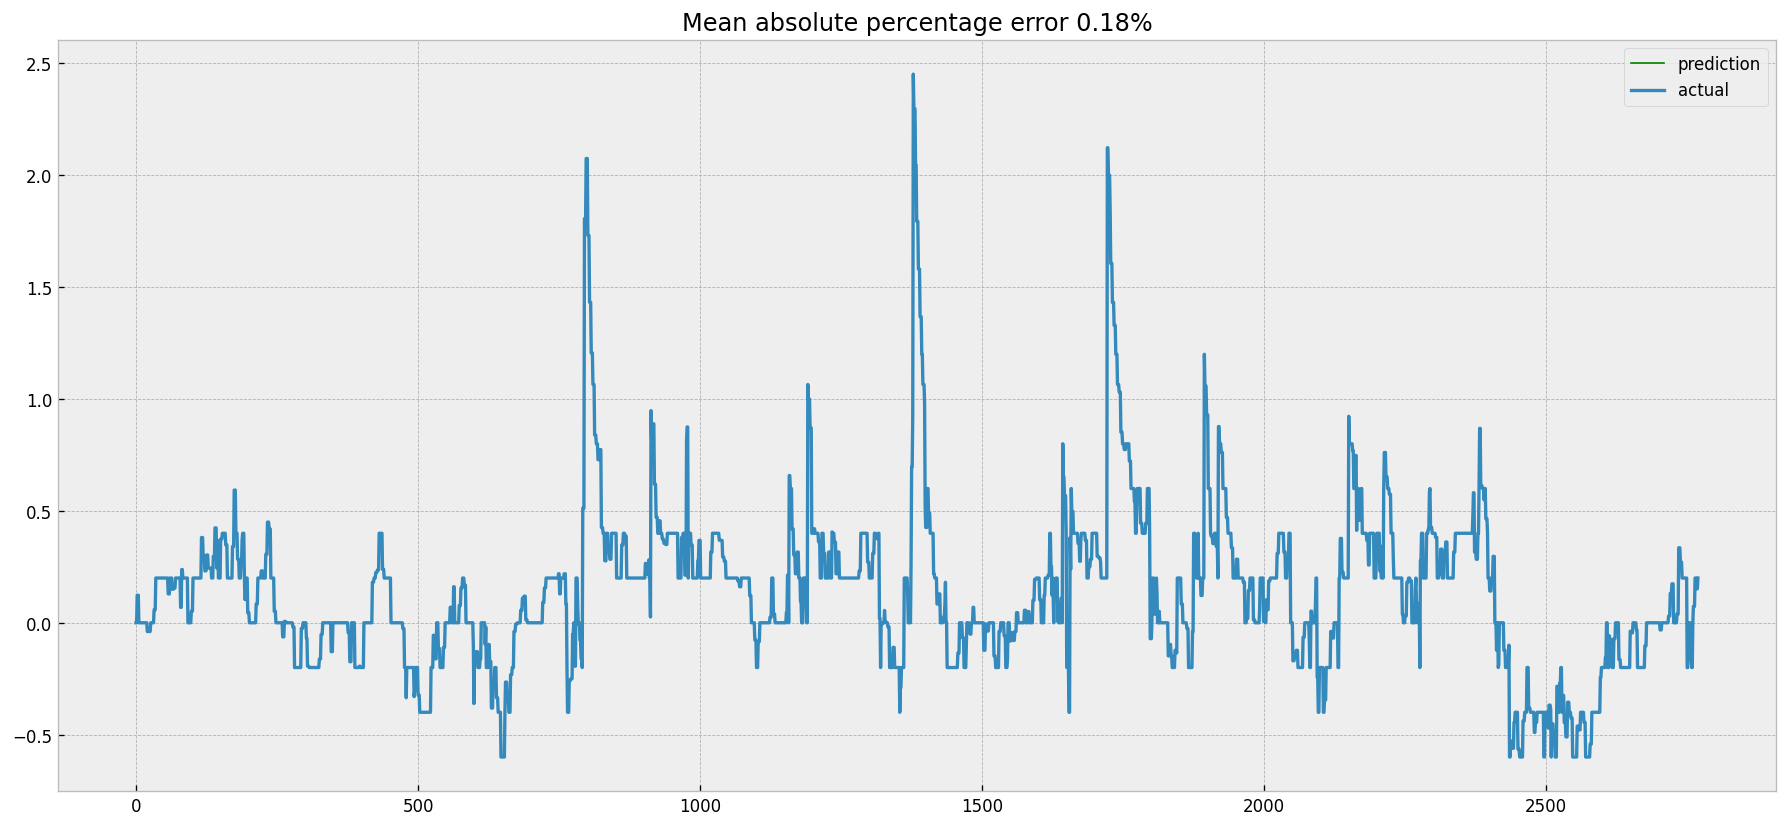

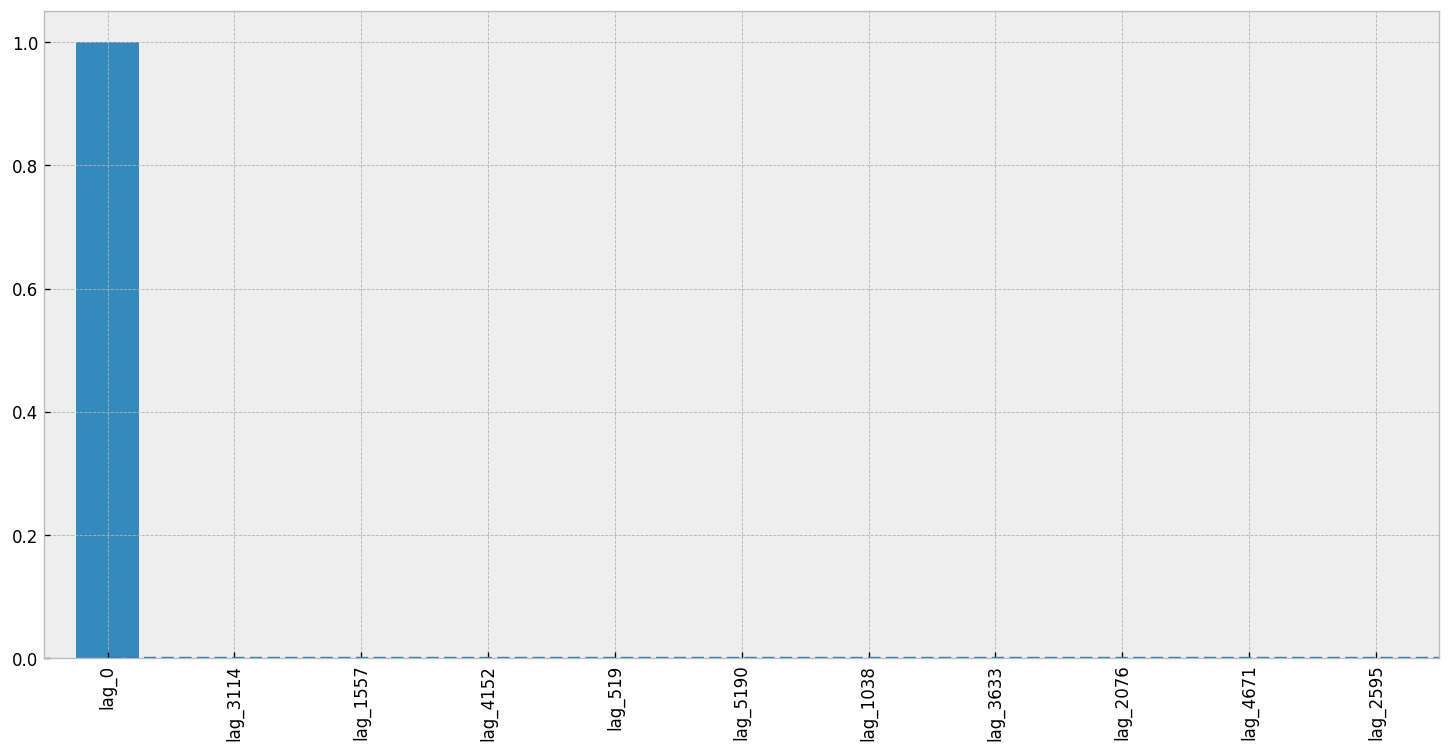

In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
#from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

#-------------------- Example using scikit-learn
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)
test_size=0.1
colour_style = "bmh"


df_lr = df.iloc[:,c]  #7 = ga_time; 3 = ba_temp
df_lr = pd.DataFrame({'y': df_lr.values})
#df_lr.columns = ["y"]

print(df_lr)
###df_lr['y'] = df_lr['AZ_Temp'] 
# Adding the lag of the target variable from 1 step(s) back up to z
for i in range(0, 5192, 519):
    df_lr["lag_{}".format(i)] = df_lr.y.shift(i)  #df_lr.y.shift(i)  #iloc[:,[0]]

# reduce rows to the ones with values in it
y = df_lr.dropna().y
x = df_lr.dropna().drop(['y'], axis=1)

print(df_lr.tail())
# get the index after which test set starts
test_index = int(len(x)*(1-test_size))

# 04 trend
x_train = x.iloc[:test_index] #utc
y_train = y.iloc[:test_index]#, 1] #az temp

x_test = x.iloc[test_index:] 
y_test = y.iloc[test_index:]#, 1] 



lr = linear_model.LinearRegression()
lr.fit(x_train, y_train) #LinearRegression instance is fitted
y_pred = lr.predict(x_test)
print(f'Linear regression of '+cn)
print('The coefficient is: {0}'.format(lr.coef_))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('The intercept is: {0}'.format(lr.intercept_))
print('The coefficient of determination of the values is: {0}'.format(r2_score(y_test, y_pred)))



#def mean_absolute_percentage_error(y_true, y_pred):
#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def plotModelResults(model, X_train=x_train, X_test=x_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """
    
    prediction = model.predict(x_test)

    with plt.style.context(colour_style):
        plt.figure(figsize=(15, 7))
        plt.plot(prediction, "g", label="prediction", linewidth=1.0)
        plt.plot(y_test.values, label="actual", linewidth=2.0)
        
        if plot_intervals:
            cv = cross_val_score(model, X_train, y_train,
                                        cv=tscv,
                                        scoring="neg_mean_absolute_error")
            mae = cv.mean() * (-1)
            deviation = cv.std()

            scale = 1.96
            lower = prediction - (mae + scale * deviation)
            upper = prediction + (mae + scale * deviation)

            plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
            plt.plot(upper, "r--", alpha=0.5)

            if plot_anomalies:
                anomalies = np.array([np.NaN]*len(y_test))
                anomalies[y_test<lower] = y_test[y_test<lower]
                anomalies[y_test>upper] = y_test[y_test>upper]
                plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

        error = mean_absolute_percentage_error(prediction, y_test)
        plt.title("Mean absolute percentage error {0:.2f}%".format(error))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True)

def plotCoefficients(trend):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(trend.coef_, x_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    with plt.style.context(colour_style):
        plt.figure(figsize=(15, 7))
        coefs.coef.plot(kind='bar')
        plt.grid(True, axis='y')
        plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')


plotModelResults(lr)#, plot_intervals=True)
plotCoefficients(lr)   

In [23]:
t = range(df_short.index.size)
t
s = df_short.index.month.astype('category')
s

AttributeError: 'RangeIndex' object has no attribute 'month'

In [96]:
from statsmodels.formula.api import ols
model = ols('df_short ~ t + s', data = df_short).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df_short   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3212.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:05:57   Log-Likelihood:            -1.5444e+05
No. Observations:              359580   AIC:                         3.089e+05
Df Residuals:                  359567   BIC:                         3.091e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1672      0.002    -71.778      0.000      -0.172      -0.163
s[T.2]         0.2406      0.003     78.911      0.000       0.235       0.247
s[T.3]         0.1607      0.003     54.009      0.000       0.155       0.167
s[T.4]         0.0543      0.003     18.113      0.000       0.048       0.060
s[T.5]         0.0660      0.003     22.171      0.000       0.060       0.072
s[T.6]         0.1616      0.003     53.841      0.000       0.156       0.168
s[T.7]         0.1419      0.003     47.651      0.000       0.136       0.148
s[T.8]         0.1398      0.003     46.915      0.000       0.134       0.146
s[T.9]        -0.1221      0.003    -39.945      0.000      -0.128      -0.116
s[T.10]        0.1253      0.003     40.455      0.000       0.119       0.131
s[T.11]       -0.0504      0.003    -16.507      0.000      -0.056      -0.044
s[T.12]       -0.1144      0.003    -38.454      0.000      -0.120      -0.109
t           4.522e-07   6.01e-09     75.298      0.000     4.4e-07    4.64e-07
==============================================================================
Omnibus:                   128802.698   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           729739.276
Skew:                           1.626   Prob(JB):                         0.00
Kurtosis:                       9.175   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df_short,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used", 
                                                        "Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0    -21.385637              Test Statistics
1      0.000000                      p-value
2      7.000000             No. of lags used
3  32876.000000  Number of observations used
4     -3.430549          critical value (1%)
5     -2.861628          critical value (5%)
6     -2.566817         critical value (10%)
